In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os

from core.data  import pretraining_records

%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [4]:
dath_path = './data/records/macho/'

In [5]:
batches = pretraining_records(os.path.join(dath_path, 'train'), 10, max_obs=200)

2022-01-12 12:07:47.284479: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 12:07:48.995192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22355 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-01-12 12:07:48.996626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22355 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:82:00.0, compute capability: 8.6
2022-01-12 12:07:48.997962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [6]:
def get_angles_original(times, d_model, base=1000):
    dim_indices = tf.range(d_model, dtype=tf.float32)

    exponent = tf.divide(tf.multiply(2., dim_indices),
                         tf.cast(d_model, tf.float32))

    angle_rates = tf.pow(tf.cast(base, dtype=tf.float32), exponent)
    angle_rates = tf.math.reciprocal(angle_rates)
    angle_rates = times * angle_rates
    return angle_rates

In [7]:
def get_angles_proposed(times, d_model):
    with tf.name_scope("Get_Angles") as scope:
        t_init = tf.math.log(3/24) # 3 hours in days
        t_end = tf.math.log(3.*365) #3 years in days
        # Sample in log space
        exponents = tf.linspace(t_init, t_end, d_model)
        # Transform to normal space
        angle_rates = tf.math.divide_no_nan(1.0, tf.exp(exponents))
        # Compute the angular frequency
        angle_rates = 2*3.14159*angle_rates
        # Compute the argument of the trig functions
        angle_rates = times * angle_rates
        return angle_rates

In [8]:
def positional_encoding(times, d_model, base=1000, mjd=False, proposed=False):
    with tf.name_scope("PosEncoding") as scope:
        if mjd:
            indices = times
        else:
            indices = tf.range(tf.shape(times)[1], dtype=tf.float32)
            indices = tf.expand_dims(indices, 0)
            indices = tf.tile(indices, [tf.shape(times)[0], 1])
            indices = tf.expand_dims(indices, 2)
        
        if proposed:
            angle_rads = get_angles_proposed(indices, d_model)
        else:
            angle_rads = get_angles_original(indices, d_model)
            
        # SIN AND COS
        def fn(x):
            if x[1] % 2 == 0:
                return (tf.sin(x[0]), x[1])
            else:
                return (tf.cos(x[0]), x[1])

        x_transpose = tf.transpose(angle_rads, [2,1,0])
        indices = tf.range(0, tf.shape(x_transpose)[0])
        x_transpose = tf.map_fn(lambda x: fn(x),  (x_transpose, indices))[0]
        pos_encoding = tf.transpose(x_transpose, [2, 1, 0])
        return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
dim_model = 256

In [11]:
oid = 'F_1.4175.3433'.encode("utf-8")
for batch in batches:
    if oid in batch['id']:
        print(batch['id'][batch['id'] == oid])
        
        original_transformer = positional_encoding(batch['times'], dim_model, mjd=False)[1]
        original_with_time   = positional_encoding(batch['times'], dim_model, mjd=True)[1]
        proposed_with_time   = positional_encoding(batch['times'], dim_model, mjd=True, proposed=True)[1]

        dotprod_original      = tf.tensordot(original_transformer, original_transformer, axes = [[1], [1]])
        dotprod_original_time = tf.tensordot(original_with_time, original_with_time, axes = [[1], [1]])
        dotprod_proposed      = tf.tensordot(proposed_with_time, proposed_with_time, axes = [[1], [1]])
        break

tf.Tensor(
[b'F_1.4175.3433' b'F_1.4175.3433' b'F_1.4175.3433' b'F_1.4175.3433'
 b'F_1.4175.3433' b'F_1.4175.3433'], shape=(6,), dtype=string)


2022-01-12 12:08:19.379977: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-01-12 12:08:19.381690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


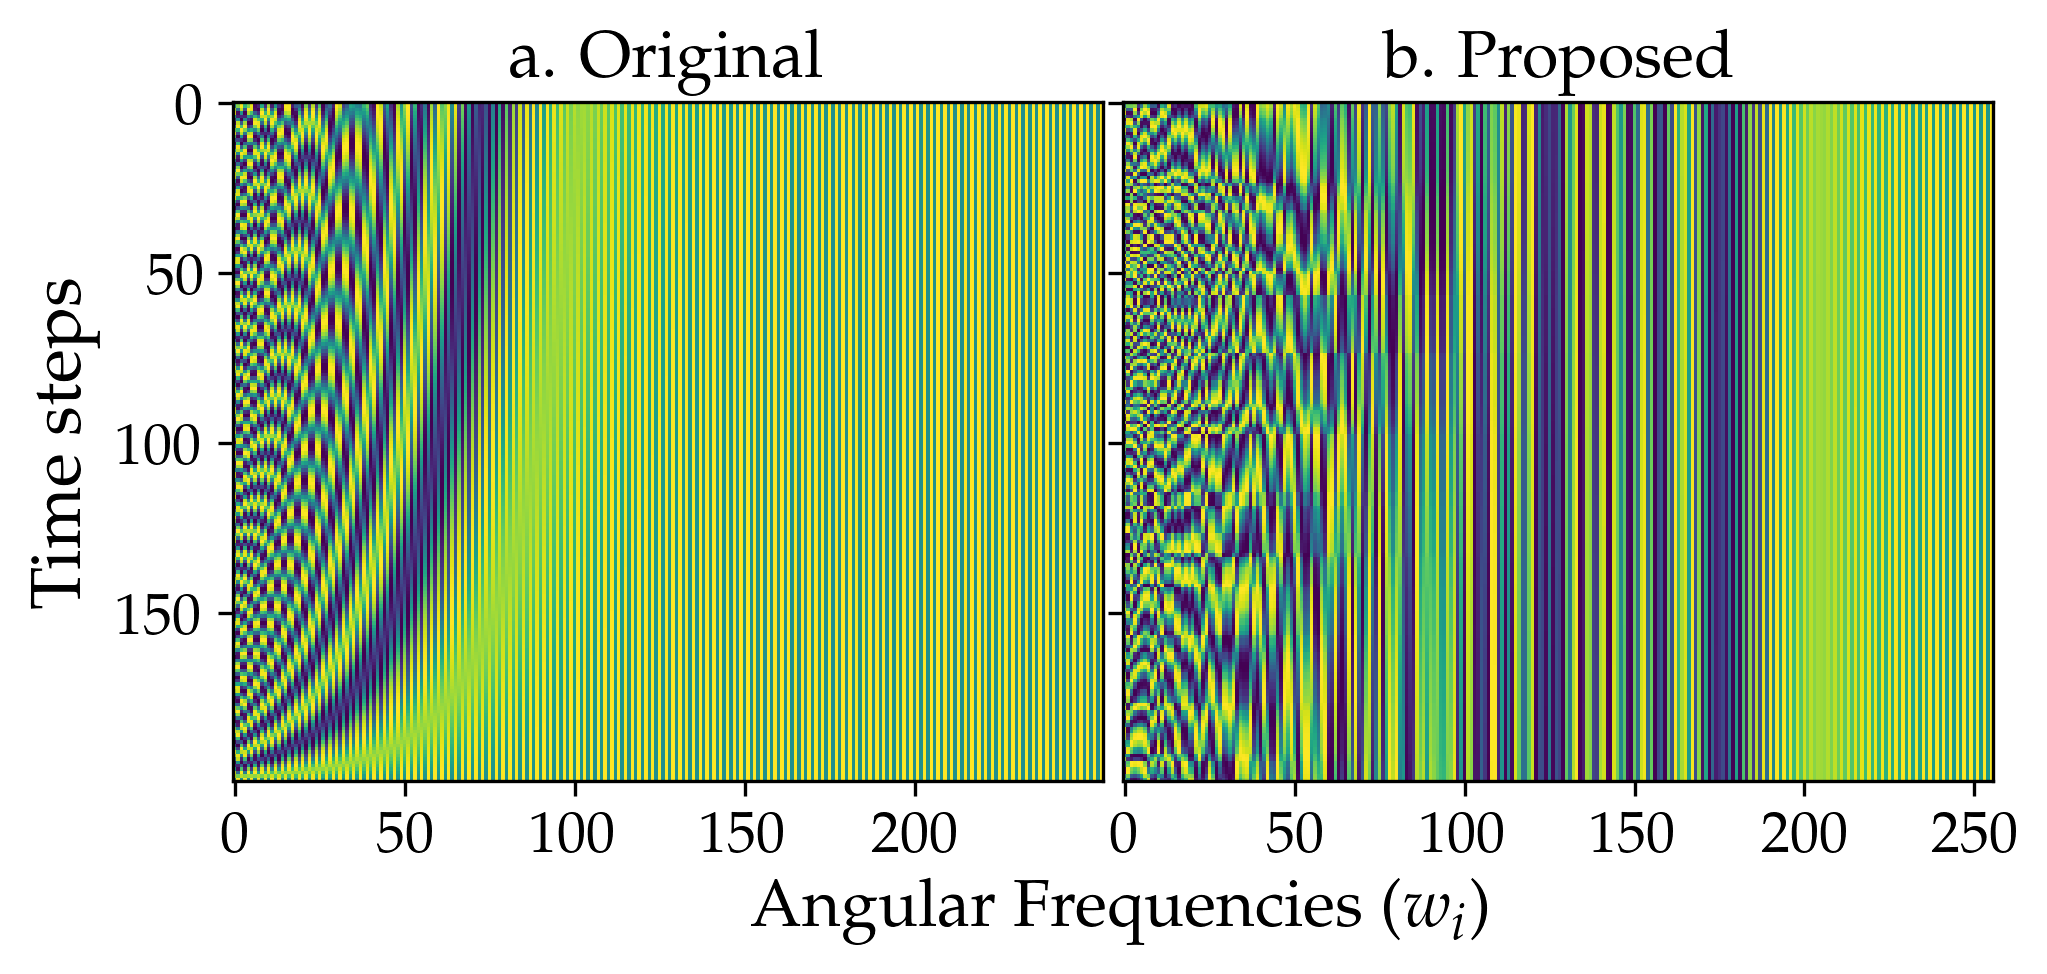

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10,3), 
                         sharey=True, 
                         dpi=300,
                         gridspec_kw={'hspace': 0, 'wspace': -0.38})

n = 200

axes[0].imshow(original_transformer[::-1], interpolation='nearest')
axes[0].set_ylabel('Time steps', fontsize=17)
axes[1].imshow(original_with_time[::-1], interpolation='nearest')

axes[0].set_yticks(range(0, n, 50))
axes[0].set_yticklabels(range(0, n, 50), fontsize=14)

axes[0].set_xticks(np.arange(0, dim_model, 50)[:-1])
axes[1].set_xticks(np.arange(0, dim_model, 50))
axes[0].set_xticklabels(np.arange(0, dim_model, 50)[:-1], fontsize=14)
axes[1].set_xticklabels(np.arange(0, dim_model, 50), fontsize=14)

axes[0].set_title('a. Original', fontsize=16)
axes[1].set_title('b. Proposed', fontsize=16)
fig.text(0.515, -0.035, 'Angular Frequencies ($w_i$)', ha='center',  fontsize=16)
# fig.savefig('presentation/figures/pe.png', format='png', transparent=True, bbox_inches='tight')
fig.savefig('presentation/figures/pe.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(11,3), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.}, dpi=450)


axes[0].plot(dotprod_original[0], color='darkred', label='1st')
axes[0].plot(dotprod_original[50], '-', color='darkblue', label='50th')
axes[0].set_title('Original \n(Vaswani, Ashish, et al. 2017)')

axes[1].plot(dotprod_original_time[0], color='darkred', label='1st')
axes[1].plot(dotprod_original_time[50], '-', color='darkblue', label='50th')
axes[1].set_title('Original \n+ Absolute Sampling Times')

axes[2].plot(dotprod_proposed[0], color='darkred', label='1st')
axes[2].plot(dotprod_proposed[50], '-', color='darkblue', label='50th')
axes[2].set_title('Proposed')

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_ylabel('PE Dot Product')

fig.text(0.5, 0.0, 'Time Step', ha='center')
fig.text(0.5, 1.04, 'Positional Encoding Dot Product', ha='center', fontsize=15)

Text(0.5, 1.04, 'Positional Encoding Dot Product')